# Imports and Configs

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_array
from sklearn.ensemble import (
    StackingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_FOLDS = 5
TARGET = 'Target'

# Loading and Processing the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e6-eda-which-makes-sense
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [5]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Defining Training and Cross Validation Functions

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)

            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return self.model, oof_pred_probs, oof_preds, accs, aucs

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_bin': 86,
    'verbosity': 0,
    'max_depth': 5,
    'max_leaves': 64,
    'booster': 'gbtree',
    'n_estimators': 1539,
    'random_state': SEED,
    'enable_categorical': True,
    'gamma': 0.9069384135972282,
    'reg_alpha': 9.076826031603096,
    'subsample': 0.9335856723937552,
    'reg_lambda': 3.7191495119106976,
    'max_delta_step': 1.1802158903460869,
    'min_child_weight': 8.745168792677534,
    'colsample_bynode': 0.8390631221126779,
    'colsample_bytree': 0.5534666374509267,
    'colsample_bylevel': 0.5695267422612745,
}

cb_params = {
    'depth': 9,
    'verbose': False,
    'thread_count': -1,
    'iterations': 1830,
    'border_count': 200,
    'random_state': SEED,
    'min_child_samples': 4,
    'bootstrap_type': 'MVS',
    'grow_policy': 'Depthwise',
    'l2_leaf_reg': 4.349614487163372,
    'random_strength': 0.16489500172653238,
    'colsample_bylevel': 0.45740812601887504,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 77,
    'num_leaves': 42,
    'subsample_freq': 8,
    'n_estimators': 169,
    'random_state': SEED,
    'min_child_samples': 199,
    'subsample': 0.9178993412905838,
    'reg_alpha': 0.9200214666236493,
    'reg_lambda': 0.2652568189927319,
    'min_child_weight': 0.4410010971781976,
    'colsample_bytree': 0.35379935570036725,
}

hgb_params = {
    'verbose': 0,
    'max_depth': 4,
    'max_bins': 250,
    'max_iter': 1522,
    'max_leaf_nodes': 92,
    'random_state': SEED,
    'min_samples_leaf': 44,
    'l2_regularization': 0.4495943539321024,
}

gb_params = {
    'verbose': 0,
    'max_depth': 4,
    'subsample': 0.9,
    'n_estimators': 600,
    'random_state': SEED,
    'learning_rate': 0.05,
}

rf_params = {
    'verbose': 0,
    'max_depth': None,
    'n_estimators': 1200,
    'random_state': SEED,
}

In [9]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

# Training Base Models

In [10]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_pred_probs, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
oof_pred_probs['XGB'] = xgb_oof_pred_probs
oof_preds['XGB'] = xgb_oof_preds
test_pred_probs['XGB'] = xgb_model.predict_proba(test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs

cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_model, cb_oof_pred_probs, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
oof_pred_probs['CB'] = cb_oof_pred_probs
oof_preds['CB'] = cb_oof_preds
test_pred_probs['CB'] = cb_model.predict_proba(test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_pred_probs, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
oof_preds['LGBM'] = lgbm_oof_preds
test_pred_probs['LGBM'] = lgbm_model.predict_proba(test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs

hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_model, hgb_oof_pred_probs, hgb_oof_preds, hgb_accs, hgb_aucs = Trainer(hgb_model).fit(X, y)
oof_pred_probs['HGB'] = hgb_oof_pred_probs
oof_preds['HGB'] = hgb_oof_preds
test_pred_probs['HGB'] = hgb_model.predict_proba(test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs

gb_model = GradientBoostingClassifier(**gb_params)
gb_model, gb_oof_pred_probs, gb_oof_preds, gb_accs, gb_aucs = Trainer(gb_model).fit(X, y)
oof_pred_probs['GB'] = gb_oof_pred_probs
oof_preds['GB'] = gb_oof_preds
test_pred_probs['GB'] = gb_model.predict_proba(test)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs

rf_model = RandomForestClassifier(**rf_params)
rf_model, rf_oof_pred_probs, rf_oof_preds, rf_accs, rf_aucs = Trainer(rf_model).fit(X, y)
oof_pred_probs['RF'] = rf_oof_pred_probs
oof_preds['RF'] = rf_oof_preds
test_pred_probs['RF'] = rf_model.predict_proba(test)
accuracies['RF'] = rf_accs
aucs['RF'] = rf_aucs

Training XGBClassifier
--- Fold 1 - Accuracy: 0.836644, AUC: 0.930521
--- Fold 2 - Accuracy: 0.837101, AUC: 0.932307
--- Fold 3 - Accuracy: 0.835403, AUC: 0.929514
--- Fold 4 - Accuracy: 0.833235, AUC: 0.929363
--- Fold 5 - Accuracy: 0.825590, AUC: 0.924143

------ Accuracy: 0.833595 ± 0.004221
------ AUC:      0.929170 ± 0.002724


Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.836448, AUC: 0.930153
--- Fold 2 - Accuracy: 0.837493, AUC: 0.932018
--- Fold 3 - Accuracy: 0.834422, AUC: 0.929325
--- Fold 4 - Accuracy: 0.832843, AUC: 0.929248
--- Fold 5 - Accuracy: 0.826897, AUC: 0.924452

------ Accuracy: 0.833621 ± 0.003727
------ AUC:      0.929039 ± 0.002501


Training LGBMClassifier
--- Fold 1 - Accuracy: 0.837036, AUC: 0.930935
--- Fold 2 - Accuracy: 0.836317, AUC: 0.932722
--- Fold 3 - Accuracy: 0.836579, AUC: 0.930180
--- Fold 4 - Accuracy: 0.834804, AUC: 0.930146
--- Fold 5 - Accuracy: 0.826635, AUC: 0.924594

------ Accuracy: 0.834274 ± 0.003892
------ AUC:      0.929715 ± 

# Training Stacking Model

In [11]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2851035
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_oof_pred_probs = pd.DataFrame(np.hstack(list(oof_pred_probs.values())))
X_test_pred_probs = pd.DataFrame(np.hstack(list(test_pred_probs.values())))

estimators = [
    ('XGB', PassThroughClassifier(list(range(3)))),
    ('CB', PassThroughClassifier(list(range(3, 6)))),
    ('LGBM', PassThroughClassifier(list(range(6, 9)))),
    ('HGB', PassThroughClassifier(list(range(9, 12)))),
    ('GB', PassThroughClassifier(list(range(12, 15)))),
    ('RF', PassThroughClassifier(list(range(15, 18))))
]

stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
stacking_model, stacking_oof_pred_probs, stacking_oof_preds, stacking_accs, stacking_aucs = Trainer(stacking_model).fit(X_oof_pred_probs, y)
oof_pred_probs['Stacking'] = stacking_oof_pred_probs
oof_preds['Stacking'] = stacking_oof_preds
test_pred_probs['Stacking'] = stacking_model.predict_proba(X_test_pred_probs)
accuracies['Stacking'] = stacking_accs
aucs['Stacking'] = stacking_aucs

Training StackingClassifier
--- Fold 1 - Accuracy: 0.836971, AUC: 0.928895
--- Fold 2 - Accuracy: 0.836905, AUC: 0.930439
--- Fold 3 - Accuracy: 0.835599, AUC: 0.928016
--- Fold 4 - Accuracy: 0.834869, AUC: 0.928703
--- Fold 5 - Accuracy: 0.826178, AUC: 0.922360

------ Accuracy: 0.834104 ± 0.004042
------ AUC:      0.927682 ± 0.002777




# Visualizing The Results

In [12]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

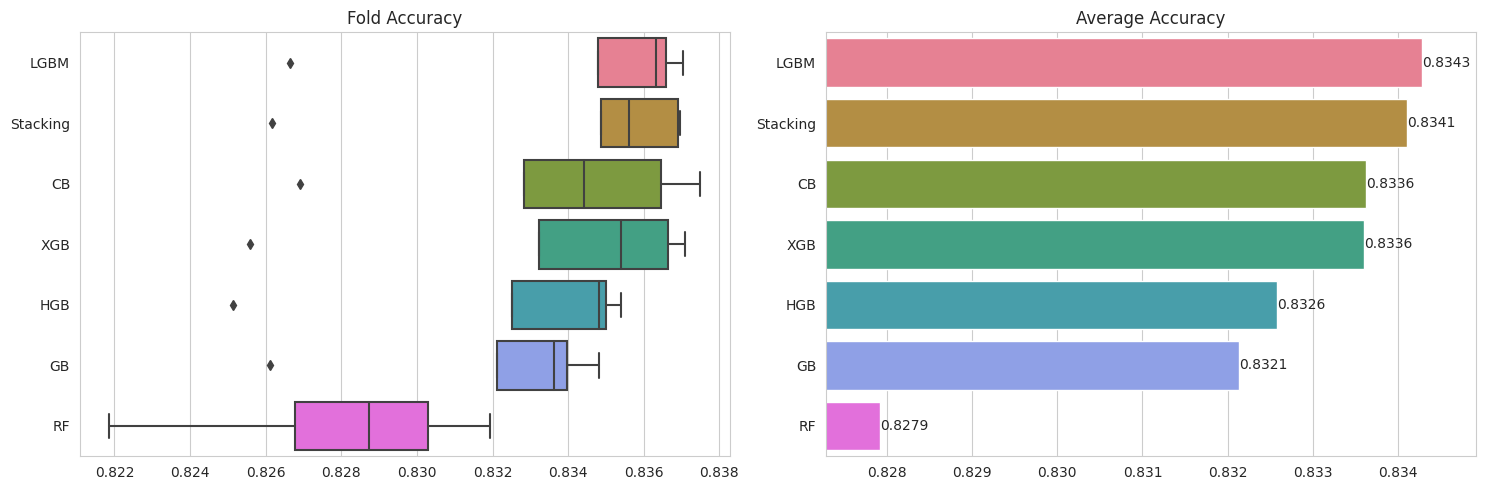

In [13]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

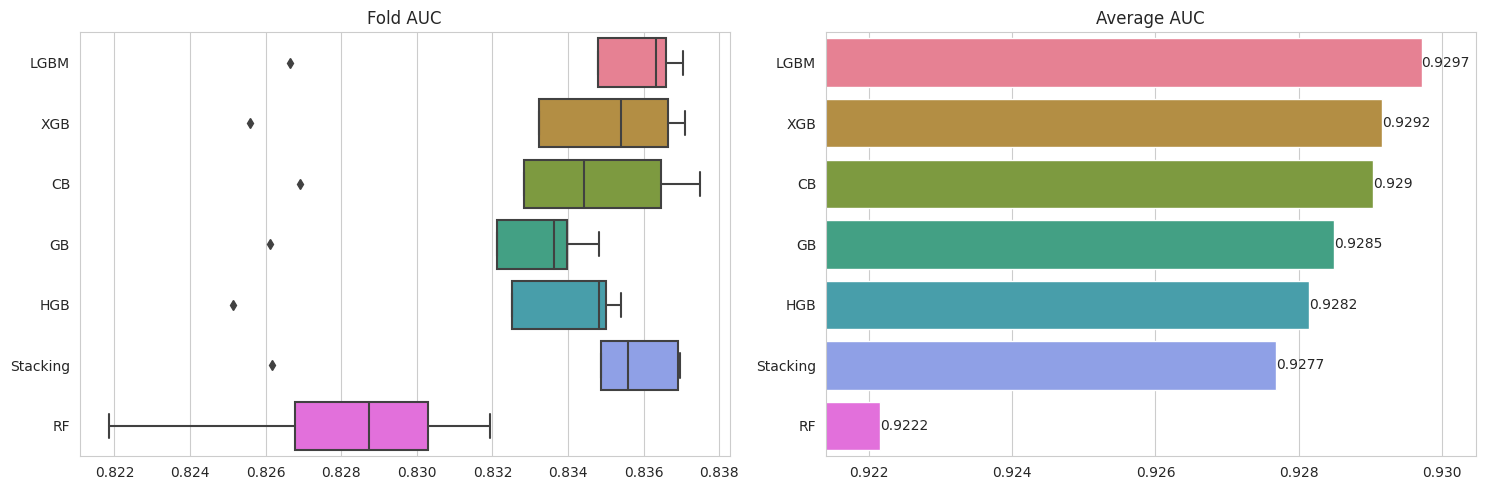

In [14]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

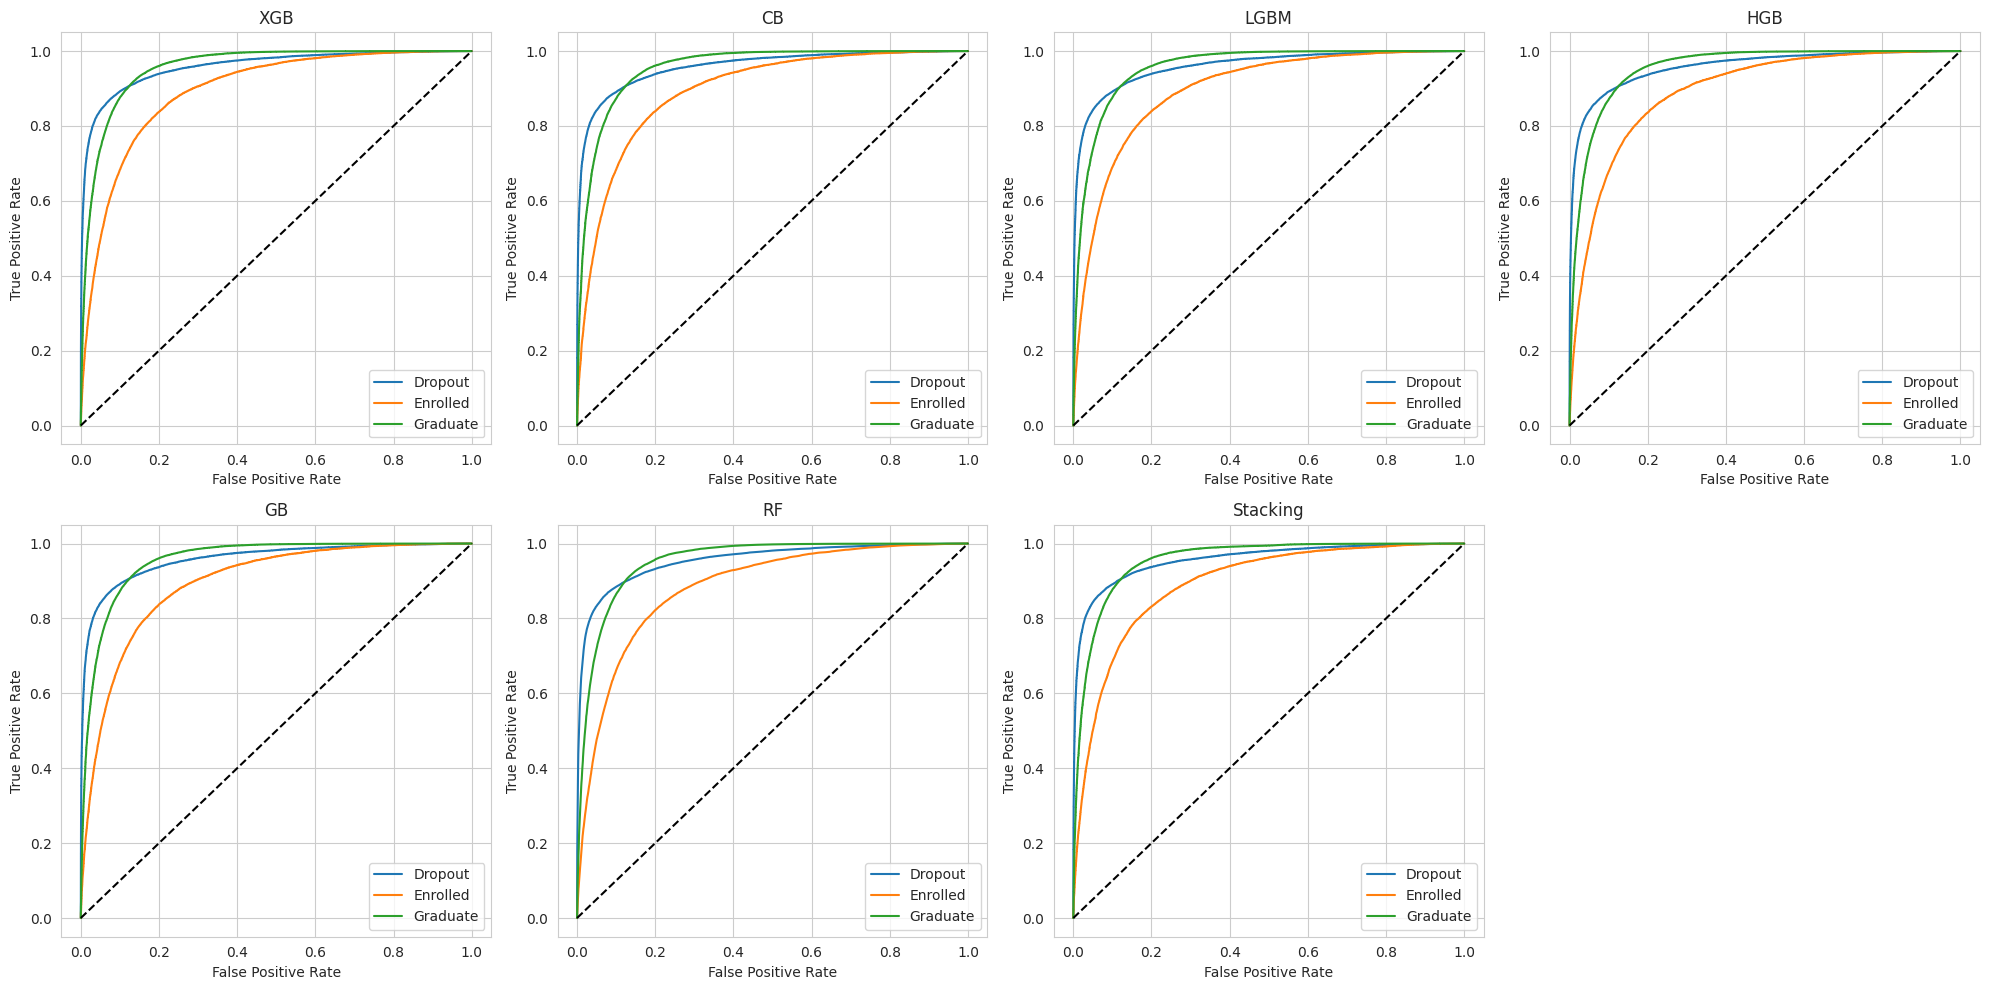

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y, pred_probs[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')
        
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

fig.delaxes(axs.flatten()[-1])
plt.tight_layout()
plt.show()

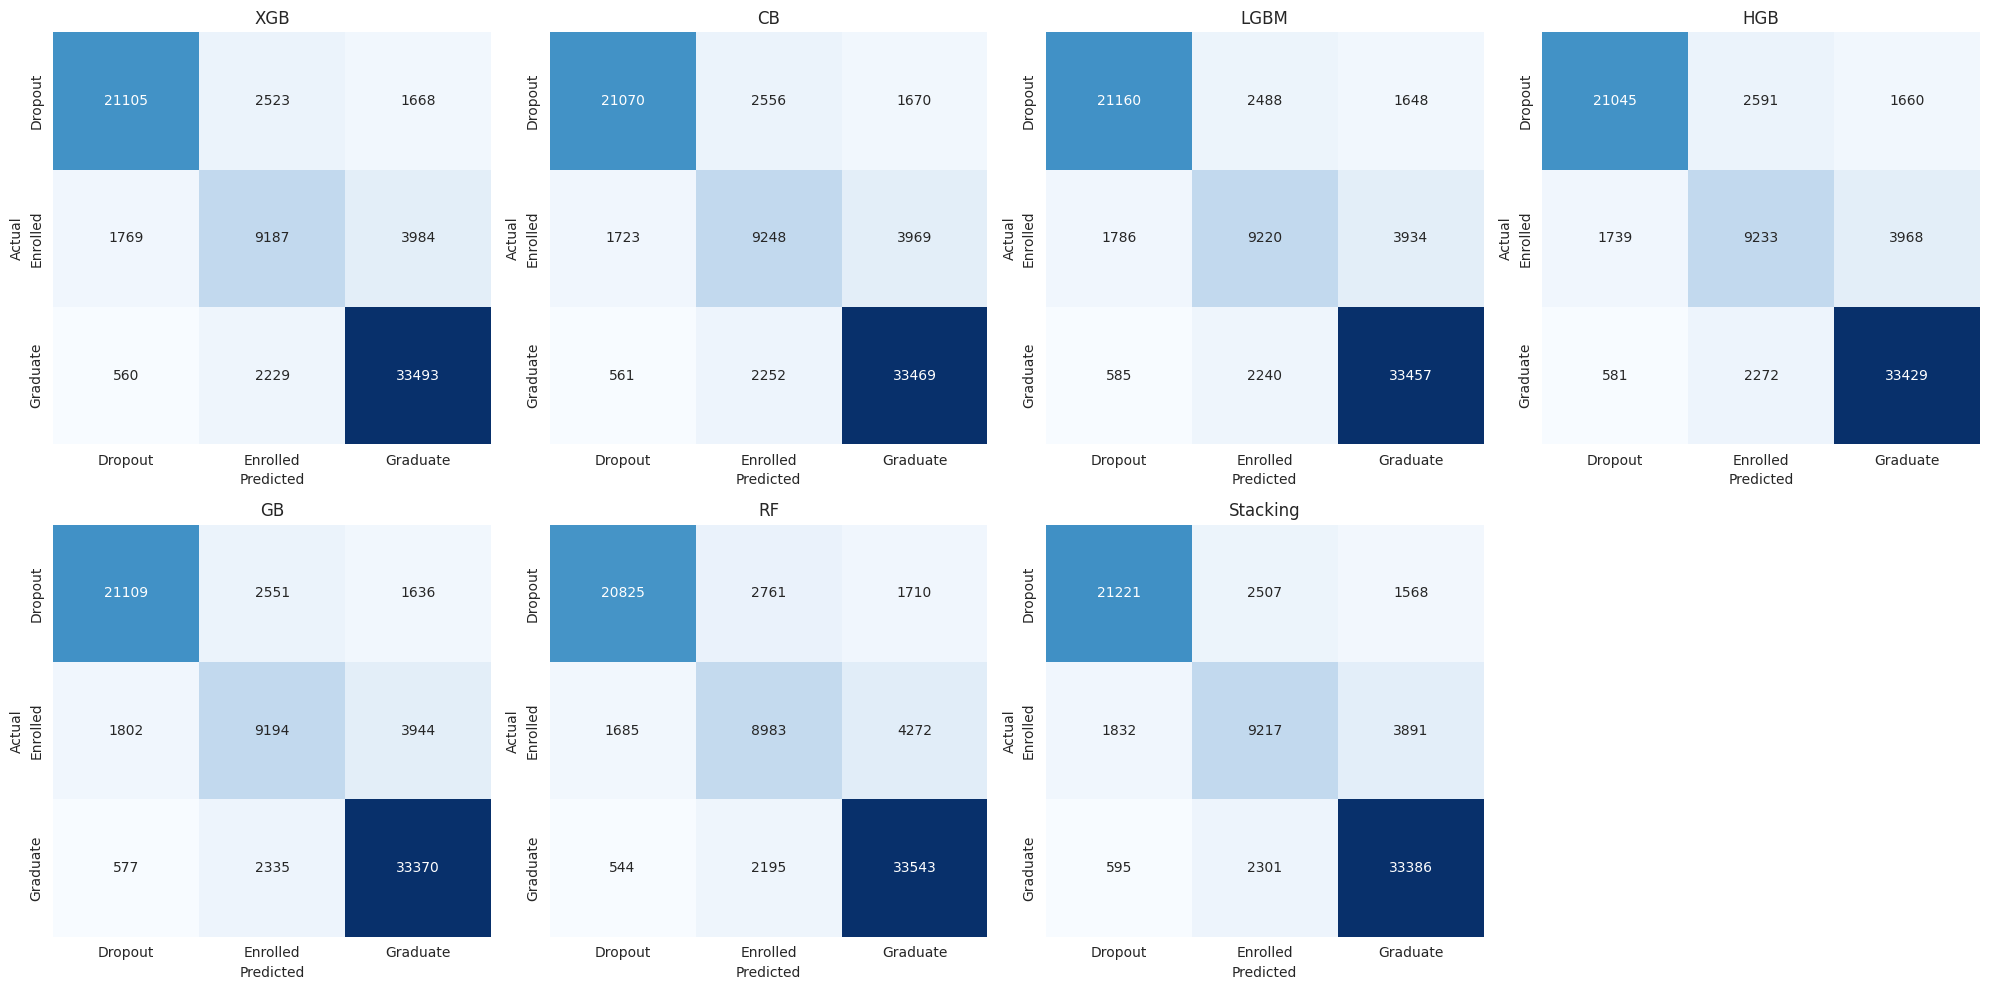

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    y_pred = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        cmap='Blues',
        ax=ax, 
        xticklabels=label_encoder.classes_, 
        yticklabels=label_encoder.classes_, 
        cbar=False,
        fmt='d'
    )
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

fig.delaxes(axs.flatten()[-1])
plt.tight_layout()
plt.show()

# Post-Processing and Creating a Submission File

In [17]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
submission['Target'] = np.argmax(test_pred_probs['Stacking'], axis=1)
submission['Target'] = label_encoder.inverse_transform(submission['Target'])
submission.to_csv(f'stacking_acc-{mean_accs["Stacking"]:.6f}_auc-{mean_aucs["Stacking"]:.6f}.csv', index=False)

In [18]:
os.mkdir('oof_pred_probs')
os.mkdir('test_pred_probs')

for model, pred_probs in oof_pred_probs.items():
    with open(f'oof_pred_probs/{model.lower()}_oof_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)
        
for model, pred_probs in test_pred_probs.items():
    with open(f'test_pred_probs/{model.lower()}_test_pred_probs.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

In [19]:
shutil.rmtree("catboost_info")